In [1]:
import os
import os.path as path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from utils import anonymize_data, patients_data, get_markers, get_foot_events, extract_data
from utils import DATA_FOLDER, OUT_FOLDER

SUGGESTED_MARKERS = {"C7", "REP", "RUL", "RASIS", "RPSIS", "RCA", "RGT",
                     "RLE", "RFM", "RA", "LEP", "LUL", "LASIS",
                     "LPSIS", "LCA", "LGT", "LLE", "LFM", "LA"}

SUGGESTED_ANGLES = {"RAAngle", "LAAngle", "RKAngle", "LKAngle", "RHAngle", "LHAngle",
                    "RPelvisAngle", "LPelvisAngle", "RTRKAngle", "LTRKAngle",
                    "LFootProgressionAngle", "RFootProgressionAngle"}

## Make data anonymous

In [2]:
# WARNING: this actually renames the original folders and files, make sure you have a backup of the data.
# WARNING: this doesn't make data completely anonymous, as some fields in the c3ds still contains the patients info
# This should at least avoid printing the patients name in notebooks output
# and make them readable in the repository history.
anonymize_data()

## Detect and remove copies

In [3]:
delete_copies = False

size_map = {}
copies = []

patients_iterator = patients_data()
for reader, class_folder, patient_folder, patient_file in patients_iterator:
    fullpath = path.join(DATA_FOLDER, class_folder, patient_folder, patient_file)
    size = path.getsize(fullpath)
    
    curr = [class_folder, patient_folder, patient_file, reader.header]
    
    if size not in size_map:
        size_map[size] = [curr]
    else:
        # Check that the actual c3d data is similar
        for other in size_map[size]:
            same_first = other[3].first_frame == curr[3].first_frame
            same_last = other[3].last_frame == curr[3].last_frame
            
            # This is enough to determine the files are copies because
            # the only two pairs occurrences had actually files named *.c3d and *_copy.c3d
            if same_first and same_last:
                print 'Copies detected:', other[0], other[2], curr[0], curr[2]
                copies.append([other, curr])
        
        size_map[size].append(curr)

# Delete copies if needed
if delete_copies:
    for x, y in copies:
        fullpath = path.join(DATA_FOLDER, x[0], x[1], x[2])
        os.remove(fullpath)

Reading class 0
Reading class 1
Reading class 2
Reading class 3
Error reading 114_8.c3d


## Evaluate suggested markers sample coverage

In [2]:
diffs = []

for reader, class_folder, _, patient_file in patients_data():
    
    markers = get_markers(reader)
    
    diff = len(SUGGESTED_MARKERS.difference(markers))
    diff_angles = len(SUGGESTED_ANGLES.difference(markers))
    
    diffs.append([class_folder, patient_file, diff, diff_angles])

diffs = pd.DataFrame(diffs, columns=['class', 'file', 'regular', 'angles'])
diffs['all'] = diffs['regular'] + diffs['angles']

Reading class 0
Reading class 1
Reading class 2
Reading class 3
Error reading 114_8.c3d


In [3]:
print 'Coverage: %d / %d' % (len(diffs[diffs.regular == 0]), len(diffs))
print 'Coverage with angles: %d / %d' % (len(diffs[diffs.angles == 0]), len(diffs))
print 'Coverage with all: %d / %d' % (len(diffs[diffs['all'] == 0]), len(diffs))

Coverage: 1089 / 1140
Coverage with angles: 1110 / 1140
Coverage with all: 1088 / 1140


## Find optimal markers subset (TODO)

In [5]:
rows = []

for reader, _, _, _ in patients_data():

    markers = get_markers(reader)
    rows.append({marker: 1 for marker in markers})
    
df = pd.DataFrame(rows).fillna(0)

Reading class 0
Reading class 1
Reading class 2
Reading class 3
Error reading 114_8.c3d


In [8]:
marker_freqs = df.sum()

# Use coverage from suggested markers as threshold
best_cols = marker_freqs[marker_freqs >= 1090].index
n_best_cols = len(best_cols)

filtered_df = df[best_cols]

markers_counts = filtered_df.sum(axis=1)
len(markers_counts[markers_counts >= len(best_cols)])

filtered_df = filtered_df[markers_counts >= len(best_cols)]

len(filtered_df)

1071

## Count bad frames, by marker

In [6]:
bad_markers_map = {}

for reader, _, _, _ in patients_data():

    markers = get_markers(reader)

    for frame, points, analog in reader.read_frames():

        bad_markers = np.where(points[:, 4] == -1)[0]
        for marker in bad_markers:
            if marker >= 255:
                # unexpected marker
                continue
                
            if markers[marker] not in bad_markers_map:
                bad_markers_map[markers[marker]] = 1
            else:
                bad_markers_map[markers[marker]] += 1

Reading class 0
Reading class 1
Reading class 2
Reading class 3
Error reading 114_8.c3d


In [9]:
bad_markers_counts = pd.Series(bad_markers_map)
markers_counts = df.sum()

freq_markers_counts = markers_counts[markers_counts > 1000]
fred_bad_markers_counts = bad_markers_counts[freq_markers_counts.index].fillna(0)
summary_bad_markers = (fred_bad_markers_counts / freq_markers_counts).sort_values()

print summary_bad_markers[SUGGESTED_MARKERS]

# Bad frames seem to be distributed equally, no reason to discard specific markers

RFM       5.190853
LASIS     9.657498
RGT       7.941541
RUL       7.911552
LA        4.293700
LFM       6.787852
C7       10.283528
REP       6.453562
RASIS     9.879326
RPSIS     7.370896
LEP       4.616983
RLE       7.050176
LLE       6.441021
LCA       6.411609
LPSIS     7.480923
LUL       5.828365
RCA       6.260334
LGT       7.590788
RA        3.967169
dtype: float64


## Analyize bad markers distribution

In [10]:
from collections import *

files_bad_markers = {}

exit = False
sugg_markers = list(SUGGESTED_MARKERS)

for reader, c, p, f in patients_data():
    markers = get_markers(reader)
    
    if (len(SUGGESTED_MARKERS.difference(markers)) > 0):
        # Skip samples not covered by suggested markers
        continue
    
    markers_indices = OrderedDict([(markers.index(marker), marker) for marker in sugg_markers])
    
    has_bad_data = False
    bad_data = {}
    
    for frame, points, _ in reader.read_frames():
        bad_markers = np.where(points[:, 4] == -1)[0]
        bad_markers = [markers_indices[bad_marker] for bad_marker in bad_markers if bad_marker in markers_indices]
        
        for bad_marker in bad_markers:
            has_bad_data = True
            if bad_marker not in bad_data:
                bad_data[bad_marker] = [frame]
            else:
                bad_data[bad_marker].append(frame)
            
    if has_bad_data:
        files_bad_markers[f] = {
            'start': reader.header.first_frame,
            'end': reader.header.last_frame,
            'data': bad_data
        }

Reading class 0
Reading class 1
Reading class 2
Reading class 3
Error reading 114_8.c3d


In [11]:
# Build a dataframe from data for better manipulation and analysis

rows = []
for f, data in files_bad_markers.items():
    
    for marker, bad_frames in data['data'].items():
        
        # Retrieve for each file and bad marker, the streaks of bad markers.
        # This is because initial analysis have shown that bad markers are usually in streaks.
        # This is in contrast with the max_gap value in c3d headers, which is always 0
        
        streaks = [[bad_frames[0]]]
        for frame in bad_frames[1:]:
            
            streak_found = False
            for streak in streaks:
                if streak[-1] == frame-1:
                    streak.append(frame)
                    streak_found = True
                    break

            if not streak_found:
                streaks.append([frame])
                    
        for streak in streaks:
            rows.append([
                f,
                data['start'],
                data['end'],
                marker,
                streak[0],
                streak[-1]
            ])

print 'Total number of streaks:', len(rows)
            
df_bad_frames = pd.DataFrame(rows, columns=['file', 'start', 'end', 'marker', 'streak_start', 'streak_end'])
df_bad_frames.to_csv('bad_frames.csv', index=False) # Save for future analysis
df_bad_frames.head(5)

Total number of streaks: 1433


,file,start,end,marker,streak_start,streak_end
0,108_5.c3d,293,859,C7,839,859
1,148_2.c3d,51,409,RGT,51,86
2,80_5.c3d,281,580,LGT,580,580
3,146_2.c3d,189,601,RLE,189,221
4,146_2.c3d,189,601,RUL,189,195


In [13]:
# Read bad frames data from csv
df_bad_frames = pd.read_csv('bad_frames.csv')

In [14]:
# Add useful derived data
df_bad_frames['sample_length'] = df_bad_frames.end - df_bad_frames.start + 1

df_bad_frames['streak_length'] = df_bad_frames.streak_end - df_bad_frames.streak_start + 1
df_bad_frames['streak_length_perc'] = df_bad_frames.streak_length / df_bad_frames.sample_length

df_bad_frames['streak_start_perc'] = (df_bad_frames.streak_start - df_bad_frames.start) / df_bad_frames.sample_length
df_bad_frames['streak_end_perc'] = (df_bad_frames.streak_end - df_bad_frames.start + 1) / df_bad_frames.sample_length

df_bad_frames.head(15)

,file,start,end,marker,streak_start,streak_end,sample_length,streak_length,streak_length_perc,streak_start_perc,streak_end_perc
0,108_5.c3d,293,859,C7,839,859,567,21,0.037037,0.962963,1.000000
1,148_2.c3d,51,409,RGT,51,86,359,36,0.100279,0.000000,0.100279
2,80_5.c3d,281,580,LGT,580,580,300,1,0.003333,0.996667,1.000000
3,146_2.c3d,189,601,RLE,189,221,413,33,0.079903,0.000000,0.079903
4,146_2.c3d,189,601,RUL,189,195,413,7,0.016949,0.000000,0.016949
5,171_5.c3d,207,553,LUL,538,553,347,16,0.046110,0.953890,1.000000
6,48_2.c3d,258,700,LEP,700,700,443,1,0.002257,0.997743,1.000000
7,48_2.c3d,258,700,LLE,698,700,443,3,0.006772,0.993228,1.000000
8,48_2.c3d,258,700,LGT,694,700,443,7,0.015801,0.984199,1.000000
9,150_2.c3d,106,560,C7,106,116,455,11,0.024176,0.000000,0.024176


In [9]:
# Analyze how many streaks start from the beginning or end at the end.
# These cases are easily overcomed by simply cropping the frames

starting_streaks = df_bad_frames['streak_start_perc'] == 0.0
ending_streaks = df_bad_frames['streak_end_perc'] == 1.0

n_starting_streaks = len(df_bad_frames[starting_streaks])
n_ending_streaks = len(df_bad_frames[ending_streaks])

print 'Number of streaks starting from first frame:', n_starting_streaks
print 'Number of streaks ending at last frame:', n_ending_streaks
print 'Number of streaks in the middle:' , len(df_bad_frames) - n_starting_streaks - n_ending_streaks

# Looking good

Number of streaks starting from first frame: 554
Number of streaks ending at last frame: 806
Number of streaks in the middle: 75


In [10]:
# Max streak_length_perc is scary, but luckily the 75th percentile is much lower
df_bad_frames.describe()

,start,end,streak_start,streak_end,sample_length,streak_length,streak_length_perc,streak_start_perc,streak_end_perc
count,1435.000000,1435.000000,1435.000000,1435.000000,1435.000000,1435.000000,1435.000000,1435.000000,1435.000000
mean,104.644599,852.065505,482.048084,575.222300,748.420906,94.174216,0.111659,0.529885,0.641544
std,169.019209,385.019672,435.260176,435.693709,365.086012,122.380037,0.120384,0.443873,0.430340
min,1.000000,287.000000,1.000000,1.000000,217.000000,1.000000,0.000582,0.000000,0.000582
25%,1.000000,641.000000,1.000000,196.000000,495.000000,6.000000,0.010929,0.000000,0.151198
50%,1.000000,753.000000,543.000000,610.000000,720.000000,51.000000,0.074586,0.771399,1.000000
75%,179.000000,958.000000,729.000000,783.000000,951.000000,137.500000,0.171842,0.956495,1.000000
max,1657.000000,3881.000000,3877.000000,3881.000000,3881.000000,1431.000000,0.833234,0.999271,1.000000


In [85]:
# These cannot be used, they're basically missing the markers
df_bad_frames[(df_bad_frames.streak_length_perc > 0.5) & (df_bad_frames.sample_length < 500)]

,file,start,end,marker,streak_start,streak_end,sample_length,streak_length,streak_length_perc,streak_start_perc,streak_end_perc
104,52_4.c3d,754,1071,LGT,870,1071,318,202,0.635220,0.36478,1.000000
981,165_5.c3d,339,804,LGT,339,575,466,237,0.508584,0.00000,0.508584
992,58_5.c3d,211,606,RGT,211,521,396,311,0.785354,0.00000,0.785354


In [108]:
# Let's have a look at the middle streaks
middle_streaks = ~(starting_streaks | ending_streaks)
isolated_frames = df_bad_frames.streak_length == 1

# These can be easily interpolated
print 'There are', len(df_bad_frames[middle_streaks & isolated_frames]), 'isolated frames in the middle.'

df_bad_frames[middle_streaks & ~isolated_frames].streak_length.value_counts().sort_index()

There are 34 isolated frames in the middle.


2      10
3       4
4       6
5       2
6       1
7       1
11      1
12      4
13      2
14      2
21      1
33      1
35      1
36      1
37      1
43      1
78      1
131     1
Name: streak_length, dtype: int64

In [11]:
n_streaks = df_bad_frames.file.value_counts()
len(n_streaks[n_streaks > 1])

127

## Analyze graphs (TODO)

In [10]:
data = extract_data('0', '1')
print 'Extracted', len(data), 'rows'
df = pd.DataFrame(data, columns=['class', 'patient', 'file', 'frame', 'marker', 'x', 'y', 'z', 'bad'])

Reading class 0
Extracted 1807240 rows


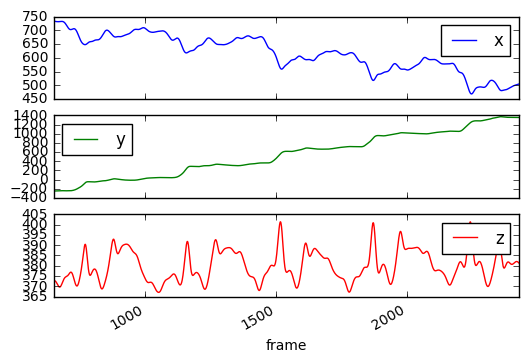

In [11]:
df[(df.marker == 'LFEO') & (df.file == '1_1.c3d')]\
    .sort_values('frame').plot('frame', ['x', 'y', 'z'], subplots=True, sharey=False)
plt.show()

## Header fields check

In [64]:
# This is needed only to show header fields
patients_iterator = patients_data()
for reader, class_folder, patient_folder, patient_file in patients_iterator:    
    print reader.header
    break

Reading class 0
  parameter_block: 2
      point_count: 162
     analog_count: 300
      first_frame: 651
       last_frame: 2426
          max_gap: 0
     scale_factor: -0.00999999977648
       data_block: 73
 analog_per_frame: 10
       frame_rate: 100.0
long_event_labels: 0
      label_block: 0


In [66]:
max_gaps = {}

patients_iterator = patients_data()
for reader, class_folder, patient_folder, patient_file in patients_iterator:
    markers = get_markers(reader)
    
    if reader.header.max_gap not in max_gaps:
        max_gaps[reader.header.max_gap] = 1
    else:
        max_gaps[reader.header.max_gap] += 1
        
max_gaps = pd.Series(max_gaps)
max_gaps

# There are only zeroes.
# Either the frame are never interpolated, or this information is missing from the original c3ds

Reading class 0
Reading class 1
Reading class 2
Reading class 3
Error reading 114_8.c3d


0    1142
dtype: int64

In [24]:
# Check consistency of info in TRIAL group and headers

patients_iterator = patients_data()
for reader, class_folder, patient_folder, patient_file in patients_iterator:
    trial_start = reader.get('TRIAL').get('ACTUAL_START_FIELD').int32_value
    trial_end = reader.get('TRIAL').get('ACTUAL_END_FIELD').int32_value
    
    header_start = reader.header.first_frame
    header_end = reader.header.last_frame
    
    if trial_start != header_start or trial_end != header_end:
        print trial_start, trial_end, header_start, header_end
        break

# Looks fine

Reading class 0
Reading class 1
Reading class 2
Reading class 3
Error reading 114_8.c3d


## Foot events

In [3]:
patients_iterator = patients_data()

invalid_times = []
exceptions = []

for reader, class_folder, patient_folder, patient_file in patients_iterator:
    try:
        l_on, l_off, r_on, r_off = get_foot_events(reader)
        times = np.concatenate((l_on, l_off, r_on, r_off))

        # Considering only positive times, should never go inside this condition
        if times.min() < 0:
            invalid_times.append([class_folder, patient_file])

    except TypeError:
        exceptions.append([class_folder, patient_file])

print len(invalid_times), 'invalid times'
print len(exceptions), 'exceptions (empty event arrays)'

Reading class 0
Reading class 1
Reading class 2
Reading class 3
Error reading 114_8.c3d
0 invalid times
2 exceptions (empty event arrays)


## Position boundaries

In [3]:
rows = []

patients_iterator = patients_data()
for reader, class_folder, patient_folder, patient_file in patients_iterator:
    markers = get_markers(reader)
    
    # (marker, x|y|z, min|max)
    bounds = np.zeros((len(markers), 3, 2))
    bounds[:, :, 0] = 10e10
    bounds[:, :, 1] = -10e10
        
    for frame, points, analog in reader.read_frames():
        bounds[:, :, 0] = np.fmin(bounds[:, :, 0], points[:, 0:3])
        bounds[:, :, 1] = np.fmax(bounds[:, :, 1], points[:, 0:3])

    all_min = np.min(bounds[:, :, 0], axis=0)
    all_max = np.max(bounds[:, :, 1], axis=0)
    
    row = [
        class_folder,
        patient_folder,
        patient_file,
        reader.header.scale_factor,
        all_min[0],
        all_max[0],
        all_min[1],
        all_max[1],
        all_min[2],
        all_max[2]
    ]
    
    # Add bounds for specific marker C7 (vertebra close to neck).
    # Probably more stable since there are some utility markers placed
    # really far from the skeleton
    try:
        c7_index = markers.index('C7')
        c7_min = bounds[c7_index, :, 0]
        c7_max = bounds[c7_index, :, 1]
        
        row.extend([
            c7_min[0],
            c7_max[0],
            c7_min[1],
            c7_max[1],
            c7_min[2],
            c7_max[2]
        ])
    except:
        pass
    
    # Add bounds for pelvis, found as middle point between RASIS, RPSIS, LASIS and LPSIS
    # Probably even stabler
    try:
        RASIS_index = markers.index('RASIS')
        RPSIS_index = markers.index('RPSIS')
        LASIS_index = markers.index('LASIS')
        LPSIS_index = markers.index('LPSIS')
        
        pelvis_min = (bounds[RASIS_index, :, 0] + bounds[RPSIS_index, :, 0] + \
                     bounds[LASIS_index, :, 0] + bounds[LPSIS_index, :, 0]) / 4.0
            
        pelvis_max = (bounds[RASIS_index, :, 1] + bounds[RPSIS_index, :, 1] + \
                     bounds[LASIS_index, :, 1] + bounds[LPSIS_index, :, 1]) / 4.0
        
        row.extend([
            pelvis_min[0],
            pelvis_max[0],
            pelvis_min[1],
            pelvis_max[1],
            pelvis_min[2],
            pelvis_max[2]
        ])
    except:
        pass
    
    rows.append(row)

Reading class 0
Reading class 1
Reading class 2
Reading class 3
Error reading 114_8.c3d


In [4]:
# Generate DataFrame with summary data
df_bounds = pd.DataFrame(rows, columns=[
    'class', 'patient', 'file', 'scale_factor',
    'min_x', 'max_x',
    'min_y', 'max_y',
    'min_z', 'max_z',
    'c7_min_x', 'c7_max_x',
    'c7_min_y', 'c7_max_y',
    'c7_min_z', 'c7_max_z',
    'p_min_x', 'p_max_x',
    'p_min_y', 'p_max_y',
    'p_min_z', 'p_max_z',
])

df_bounds.patient = pd.to_numeric(df_bounds.patient)
df_bounds.head(5)

,class,patient,file,scale_factor,min_x,max_x,min_y,max_y,min_z,max_z,...,c7_min_y,c7_max_y,c7_min_z,c7_max_z,p_min_x,p_max_x,p_min_y,p_max_y,p_min_z,p_max_z
0,0,1,1_1.c3d,-0.01,-297.186127,1644.620728,-695.424316,2152.603516,-184.325119,1233.257568,...,-189.193054,1356.158203,1125.565918,1150.222778,533.441040,782.567139,-253.646095,1309.781036,740.706558,771.550476
1,0,1,1_2.c3d,-0.01,-419.700409,1890.699829,-294.114838,1624.078003,-191.920547,1215.907837,...,567.448120,790.950439,1117.005737,1152.583252,388.400940,1424.440979,528.345070,763.049347,741.099930,770.667038
2,0,1,1_3.c3d,-0.01,-1336.119385,684.095520,-70.693817,2777.613770,-186.695572,1206.898682,...,2023.557617,2139.260254,1107.343018,1143.438721,-862.403442,-183.177719,2054.479248,2186.239685,722.971069,761.555389
3,0,1,1_4.c3d,-0.01,-73.822647,2413.872559,-72.171555,2494.879150,-202.915039,1207.077881,...,2127.331055,2231.828857,1104.286865,1136.949707,487.382744,1558.026245,2155.349792,2253.414001,720.403427,751.122574
4,0,1,1_5.c3d,-0.01,-594.534241,1515.198975,-299.986816,2062.800293,-1893.749146,1848.347778,...,1078.080444,1232.630493,1051.821411,1096.799805,233.111580,1198.115356,1074.669693,1243.146637,678.029510,731.029007


In [5]:
# The sign in scale_factor indicates that the 3D data is stored either as signed integer (positive)
# or floating-point (negative). Either way, the scale_factor is always floating-point.

positive_scale_factors = len(df_bounds[df_bounds.scale_factor > 0])
print 'Times the scale_factor is positive:', positive_scale_factors

if positive_scale_factors == 0:
    print 'This means that all 3D data is already stored as floating-point.'
    
# Only two possible values, both negatives
df_bounds.scale_factor.value_counts()

Times the scale_factor is positive: 0
This means that all 3D data is already stored as floating-point.


-0.01    928
-0.10    212
Name: scale_factor, dtype: int64

In [6]:
# Rescale bounds
df_bounds_scaled = df_bounds.copy()
df_bounds_scaled.min_x *= abs(df_bounds_scaled.scale_factor)
df_bounds_scaled.max_x *= abs(df_bounds_scaled.scale_factor)
df_bounds_scaled.min_y *= abs(df_bounds_scaled.scale_factor)
df_bounds_scaled.max_y *= abs(df_bounds_scaled.scale_factor)
df_bounds_scaled.min_z *= abs(df_bounds_scaled.scale_factor)
df_bounds_scaled.max_z *= abs(df_bounds_scaled.scale_factor)
df_bounds_scaled.c7_min_x *= abs(df_bounds_scaled.scale_factor)
df_bounds_scaled.c7_max_x *= abs(df_bounds_scaled.scale_factor)
df_bounds_scaled.c7_min_y *= abs(df_bounds_scaled.scale_factor)
df_bounds_scaled.c7_max_y *= abs(df_bounds_scaled.scale_factor)
df_bounds_scaled.c7_min_z *= abs(df_bounds_scaled.scale_factor)
df_bounds_scaled.c7_max_z *= abs(df_bounds_scaled.scale_factor)
df_bounds_scaled.p_min_x *= abs(df_bounds_scaled.scale_factor)
df_bounds_scaled.p_max_x *= abs(df_bounds_scaled.scale_factor)
df_bounds_scaled.p_min_y *= abs(df_bounds_scaled.scale_factor)
df_bounds_scaled.p_max_y *= abs(df_bounds_scaled.scale_factor)
df_bounds_scaled.p_min_z *= abs(df_bounds_scaled.scale_factor)
df_bounds_scaled.p_max_z *= abs(df_bounds_scaled.scale_factor)
df_bounds_scaled.head(5)

,class,patient,file,scale_factor,min_x,max_x,min_y,max_y,min_z,max_z,...,c7_min_y,c7_max_y,c7_min_z,c7_max_z,p_min_x,p_max_x,p_min_y,p_max_y,p_min_z,p_max_z
0,0,1,1_1.c3d,-0.01,-2.971861,16.446207,-6.954243,21.526035,-1.843251,12.332575,...,-1.891930,13.561582,11.255659,11.502228,5.334410,7.825671,-2.536461,13.097810,7.407065,7.715505
1,0,1,1_2.c3d,-0.01,-4.197004,18.906998,-2.941148,16.240780,-1.919205,12.159078,...,5.674481,7.909504,11.170057,11.525832,3.884009,14.244409,5.283451,7.630493,7.410999,7.706670
2,0,1,1_3.c3d,-0.01,-13.361194,6.840955,-0.706938,27.776137,-1.866956,12.068987,...,20.235576,21.392602,11.073430,11.434387,-8.624034,-1.831777,20.544792,21.862396,7.229711,7.615554
3,0,1,1_4.c3d,-0.01,-0.738226,24.138725,-0.721716,24.948791,-2.029150,12.070779,...,21.273310,22.318288,11.042868,11.369497,4.873827,15.580262,21.553497,22.534140,7.204034,7.511226
4,0,1,1_5.c3d,-0.01,-5.945342,15.151989,-2.999868,20.628002,-18.937491,18.483477,...,10.780804,12.326305,10.518214,10.967998,2.331116,11.981153,10.746697,12.431466,6.780295,7.310290


In [7]:
# Global bounds
print 'x: (%.2f, %.2f)' % (df_bounds_scaled.min_x.min(), df_bounds_scaled.max_x.max())
print 'y: (%.2f, %.2f)' % (df_bounds_scaled.min_y.min(), df_bounds_scaled.max_y.max())
print 'z: (%.2f, %.2f)' % (df_bounds_scaled.min_z.min(), df_bounds_scaled.max_z.max())
print 'c7_x: (%.2f, %.2f)' % (df_bounds_scaled.c7_min_x.min(), df_bounds_scaled.c7_max_x.max())
print 'c7_y: (%.2f, %.2f)' % (df_bounds_scaled.c7_min_y.min(), df_bounds_scaled.c7_max_y.max())
print 'c7_z: (%.2f, %.2f)' % (df_bounds_scaled.c7_min_z.min(), df_bounds_scaled.c7_max_z.max())
print 'p_x: (%.2f, %.2f)' % (df_bounds_scaled.p_min_x.min(), df_bounds_scaled.p_max_x.max())
print 'p_y: (%.2f, %.2f)' % (df_bounds_scaled.p_min_y.min(), df_bounds_scaled.p_max_y.max())
print 'p_z: (%.2f, %.2f)' % (df_bounds_scaled.p_min_z.min(), df_bounds_scaled.p_max_z.max())

# Bounds of marker C7 are much stabler, the following can be inferred:
# Z axis is height (0 is floor level, can't go lower than that)
# X axis is short axis (~4,7 m)
# Y axis is long axis (~6.4 m)

x: (-4883.71, 2095.90)
y: (-6675.11, 9304.38)
z: (-3377.72, 4623.15)
c7_x: (-210.21, 261.75)
c7_y: (-232.32, 399.23)
c7_z: (0.00, 148.71)
p_x: (-212.72, 267.53)
p_y: (-246.77, 391.02)
p_z: (0.00, 103.79)


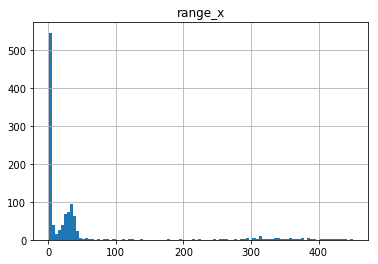

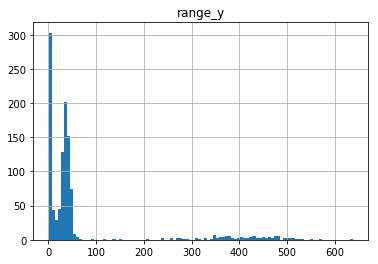

In [8]:
df_bounds_scaled['range_x'] = df_bounds_scaled.p_max_x - df_bounds_scaled.p_min_x
df_bounds_scaled['range_y'] = df_bounds_scaled.p_max_y - df_bounds_scaled.p_min_y
df_bounds_scaled['range_z'] = df_bounds_scaled.p_max_z - df_bounds_scaled.p_min_z
df_bounds_scaled.hist('range_x', bins=100)
df_bounds_scaled.hist('range_y', bins=100)
plt.show()

# Ranges are either really small (very high peak at 0) when they are not on movement axis
# (lateral movement is little and occurs only for class 1)
# or on normal distribution when they are on the movement axis
# (mean should be similar to axis length, variance relatively large e.g. 1-2 meters)

In [9]:
# Try to infer direction of the gait
df_bounds_scaled['range_ratio'] = df_bounds_scaled.range_x / df_bounds_scaled.range_y
df_bounds_scaled['main_axis'] = np.where(df_bounds_scaled.range_ratio > 1, 'x', 'y')

df_bounds_scaled.head(5)

,class,patient,file,scale_factor,min_x,max_x,min_y,max_y,min_z,max_z,...,p_max_x,p_min_y,p_max_y,p_min_z,p_max_z,range_x,range_y,range_z,range_ratio,main_axis
0,0,1,1_1.c3d,-0.01,-2.971861,16.446207,-6.954243,21.526035,-1.843251,12.332575,...,7.825671,-2.536461,13.097810,7.407065,7.715505,2.491261,15.634271,0.308439,0.159346,y
1,0,1,1_2.c3d,-0.01,-4.197004,18.906998,-2.941148,16.240780,-1.919205,12.159078,...,14.244409,5.283451,7.630493,7.410999,7.706670,10.360400,2.347043,0.295671,4.414236,x
2,0,1,1_3.c3d,-0.01,-13.361194,6.840955,-0.706938,27.776137,-1.866956,12.068987,...,-1.831777,20.544792,21.862396,7.229711,7.615554,6.792257,1.317604,0.385843,5.155005,x
3,0,1,1_4.c3d,-0.01,-0.738226,24.138725,-0.721716,24.948791,-2.029150,12.070779,...,15.580262,21.553497,22.534140,7.204034,7.511226,10.706435,0.980642,0.307191,10.917780,x
4,0,1,1_5.c3d,-0.01,-5.945342,15.151989,-2.999868,20.628002,-18.937491,18.483477,...,11.981153,10.746697,12.431466,6.780295,7.310290,9.650038,1.684769,0.529995,5.727809,x


In [10]:
df_uncertain = df_bounds_scaled[(df_bounds_scaled.range_ratio > 0.7) & (df_bounds_scaled.range_ratio < 1.43)]
print len(df_uncertain), 'patients has range_ratio between 0.7 and 1.43 (walked slightly diagonally)'

df_more_uncertain = df_bounds_scaled[(df_bounds_scaled.range_ratio > 0.85) & (df_bounds_scaled.range_ratio < 1.176)]
print len(df_more_uncertain), 'patients has range_ratio between 0.85 and 1.176 (walked almost diagonally)'

df_most_uncertain = df_bounds_scaled[(df_bounds_scaled.range_ratio > 0.95) & (df_bounds_scaled.range_ratio < 1.052)]
print len(df_most_uncertain), 'patients has range_ratio between 0.95 and 1.052 (walked diagonally)'

# It was to be expected that the patient with uncertain movement direction
# were exclusively from class 1. Instead, most of them are from class 3
df_uncertain[['class', 'range_ratio', 'main_axis']].sort_values('range_ratio')

10 patients has range_ratio between 0.7 and 1.43 (walked slightly diagonally)
7 patients has range_ratio between 0.85 and 1.176 (walked almost diagonally)
2 patients has range_ratio between 0.95 and 1.052 (walked diagonally)


,class,range_ratio,main_axis
864,3,0.747209,y
1026,3,0.762044,y
292,1,0.771119,y
776,3,0.859300,y
778,3,0.900451,y
870,3,0.911546,y
869,3,0.928023,y
871,3,0.982136,y
872,3,0.988194,y
293,1,1.102911,x


In [26]:
df_bounds_scaled['main_range'] = np.where(df_bounds_scaled.main_axis == 'x', df_bounds_scaled.range_x, df_bounds_scaled.range_y)
descr_y = df_bounds_scaled[df_bounds_scaled.main_axis == 'y'][['range_y']].describe()
descr_x = df_bounds_scaled[df_bounds_scaled.main_axis == 'x'][['range_x']].describe()
descr_main = df_bounds_scaled[['main_range']].describe()

# Cannot infer anything from range alone
pd.concat([descr_x, descr_y, descr_main], axis=1)

,range_x,range_y,main_range
count,417.000000,693.000000,1110.000000
mean,102.140796,98.352767,99.775838
std,133.803599,141.744922,138.766154
min,6.365645,8.445657,6.365645
25%,28.527201,32.873829,31.334338
50%,34.346962,38.453248,37.062323
75%,42.689093,46.450012,45.850240
max,450.806837,637.790854,637.790854


In [17]:
df_uncertain[['class', 'file', 'range_x', 'range_y', 'range_z', 'range_ratio', 'main_axis']]

,class,file,range_x,range_y,range_z,range_ratio,main_axis
292,1,54_4.c3d,20.577450,26.685173,0.300747,0.771119,y
293,1,54_5.c3d,24.926386,22.600543,0.320617,1.102911,x
776,3,124_3.c3d,320.787902,373.313134,6.308766,0.859300,y
778,3,124_5.c3d,311.753398,346.219239,6.249620,0.900451,y
864,3,136_3.c3d,17.323051,23.183688,0.884902,0.747209,y
869,3,137_4.c3d,24.138461,26.010626,0.679478,0.928023,y
870,3,137_5.c3d,19.976390,21.914836,0.368453,0.911546,y
871,3,137_6.c3d,24.170844,24.610478,0.652877,0.982136,y
872,3,137_7.c3d,21.273187,21.527338,0.629123,0.988194,y
1026,3,162_4.c3d,196.006209,257.211306,8.926199,0.762044,y


## Analysis Group

In [38]:
# Check coverage of ANALYSIS group
all_names = {}
all_units = {}

patients_iterator = patients_data()
for reader, class_folder, patient_folder, patient_file in patients_iterator:
    analysis_group = reader.get('ANALYSIS')
    names = [name.strip().replace('\xb0', '') for name in analysis_group.get('NAMES').bytes_array]
    contexts = [context.strip() for context in analysis_group.get('CONTEXTS').string_array]
    units = [unit.strip() for unit in analysis_group.get('UNITS').string_array]
    values = analysis_group.get('VALUES').float_array

    for name in set(names):
        if name not in all_names:
            all_names[name] = 1
        else:
            all_names[name] += 1
           
    for i, name in enumerate(names):
        if name not in all_units:
            all_units[name] = {units[i]}
        else:
            all_units[name].add(units[i])
    
# Almost all field are always present (values not checked)
# Opposite Foot Contact has ~70% coverage
# Speed Normalised is missing just a few, and might be computed back from Speed and patient height
# (or from ratio between Stride Length and Stride Length Normalised)
print "\n", all_names

# Units are coherent
print "\n", {str(key): + len(val) for key, val in all_units.iteritems()}

Reading class 0
Reading class 1
Reading class 2
Reading class 3
Error reading 114_8.c3d

{'1 Single Support': 1108, '1 Double Support': 1108, 'Speed': 1108, 'Swing Time': 1108, '2 Double Support': 1108, 'Speed Normalised': 1100, 'Stance Time': 1108, 'Cycle Time': 1108, 'Stride Length': 1108, 'Opposite Foot Contact': 861, 'Stride Length Normalised': 1108, 'Cadence': 1108}

{'1 Single Support': 1, '1 Double Support': 1, 'Speed': 1, 'Swing Time': 1, '2 Double Support': 1, 'Speed Normalised': 1, 'Stance Time': 1, 'Cycle Time': 1, 'Stride Length': 1, 'Opposite Foot Contact': 1, 'Stride Length Normalised': 1, 'Cadence': 1}


In [41]:
# Import data extracted from c3ds and ready to be classified
analysis_file = path.join(OUT_FOLDER, 'analysis.csv')
df = pd.read_csv(analysis_file, sep=';').drop(['patient', 'file'], axis=1)
df.head(5)

,class,Cadence Left,Speed Left,Stance Time Left,Swing Time Left,1 Double Support Left,2 Double Support Left,1 Single Support Left,Opposite Foot Contact Left,Stride Length Left,...,Stance Time Right,Swing Time Right,1 Double Support Right,2 Double Support Right,1 Single Support Right,Opposite Foot Contact Right,Stride Length Right,Stride Length Normalised Right,Cycle Time Right,Speed Normalised Right
0,0,15.263041,7.08535,91.642708,8.357289,41.010838,32.960999,17.670877,58.681713,27.385117,...,81.992615,18.007383,31.697416,41.423538,8.071189,39.768604,27.856180,20.634209,4.040000,5.309486
1,0,40.623421,8.90730,74.100937,25.899067,24.529064,20.168182,29.403687,53.932751,16.769157,...,74.206207,25.793795,24.879971,26.075706,20.958019,45.837990,16.538273,12.250572,1.823333,6.769119
2,0,15.263041,7.08535,91.642708,8.357289,41.010838,32.960999,17.670877,58.681713,27.385117,...,81.992615,18.007383,31.697416,41.423538,8.071189,39.768604,27.856180,20.634209,4.040000,5.309486
3,0,44.842678,9.72648,78.235382,21.764620,27.469210,24.573347,28.860674,56.329884,16.743834,...,73.930084,26.069918,22.638361,32.737370,18.554350,41.192711,19.590397,14.511405,1.736000,8.448244
4,0,32.122799,6.61716,84.772057,15.227945,41.580902,34.289898,12.179721,53.760616,16.474405,...,85.374123,14.625880,27.346193,47.789890,10.238034,37.584229,23.719336,17.569880,3.323333,5.107490


In [49]:
data = df.drop(['class'], axis=1).as_matrix()

print 'Has NaNs:', np.any(np.isnan(data))
print 'Has infinites:', np.any(~np.isfinite(data))

infinites = ~np.isfinite(data)

ok_idxs = np.where(~infinites)
idxs = np.where(infinites)

# There's only one
print 'Infinities:', data[idxs]

print 'Infinity surrogate:', np.max(data[ok_idxs])

Has NaNs: False
Has infinites: True
Infinities: [ inf]
Infinity surrogate: 29220454.0


## Analyze steps data

In [50]:
# Import data extracted from c3ds and ready to be classified
analysis_file = path.join(OUT_FOLDER, 'steps.csv')
df = pd.read_csv(analysis_file, sep=';')
df.head(5)

,l_on,l_off,r_on,r_off
0,10,10,10,9
1,6,5,6,6
2,4,4,4,4
3,6,6,6,5
4,5,4,5,5


In [66]:
l_on_f = df['l_on'].value_counts().sort_index()
l_off_f = df['l_off'].value_counts().sort_index()
r_on_f = df['r_on'].value_counts().sort_index()
r_off_f = df['r_off'].value_counts().sort_index()

freqs = pd.concat([l_on_f, l_off_f, r_on_f, r_off_f], axis=1).fillna(0).astype(np.int)
freqs

,l_on,l_off,r_on,r_off
0,1,1,0,1
1,2,5,4,5
2,14,44,14,38
3,136,313,197,333
4,445,365,364,378
5,276,209,301,203
6,131,87,119,73
7,41,33,49,30
8,21,13,16,10
9,9,11,14,10


In [80]:
# Show cumulative coverage (i.e. idx as min windows threshold => percentage of coverage)
cum_freqs = pd.DataFrame([
    freqs.sum() / freqs.sum(),
    freqs[1:].sum() / freqs.sum(),
    freqs[2:].sum() / freqs.sum(),
    freqs[3:].sum() / freqs.sum(),
    freqs[4:].sum() / freqs.sum(),
])
cum_freqs

,l_on,l_off,r_on,r_off
0,1.000000,1.000000,1.000000,1.000000
1,0.999081,0.999081,1.000000,0.999081
2,0.997243,0.994485,0.996324,0.994485
3,0.984375,0.954044,0.983456,0.959559
4,0.859375,0.666360,0.802390,0.653493


In [93]:
best = cum_freqs.ix[3].idxmax()
best_perc = cum_freqs.ix[3][best]
n = len(df)

print 3, best, best_perc, '%d / %d' % (best_perc*n, n)

3 l_on 0.984375 1071 / 1088
